In [1]:
import pandas as pd
import unicodedata
from pypinyin.contrib.tone_convert import to_initials, to_finals
import pycantonese

In [3]:
df = pd.read_csv('unihan/unihan.txt', sep='\t', keep_default_na=False)
df

,character,language,value
0,U+3400,kCantonese,jau1
1,U+3400,kDefinition,(same as U+4E18 丘) hillock or mound
2,U+3400,kMandarin,qiū
3,U+3401,kCantonese,tim2
4,U+3401,kDefinition,"to lick; to taste, a mat, bamboo bark"
...,...,...,...
196650,U+30729,kHangul,은:N
196651,U+30EDD,kDefinition,biangbiang noodles
196652,U+30EDD,kMandarin,biáng
196653,U+30EDE,kDefinition,biangbiang noodles


In [74]:
df2 = pd.read_csv('unihan/hk_freq.txt', sep='\t', keep_default_na=False)
df2

,character,trans_character
0,U+4E00,一
1,U+4E01,丁
2,U+4E03,七
3,U+4E09,三
4,U+4E0B,下
...,...,...
4819,U+9F77,齷
4820,U+9F72,齲
4821,U+9F8D,龍
4822,U+9F94,龔


In [81]:
table = pd.merge(df,df2,on='character')
table = table[table['language'].isin(['kCantonese','kMandarin'])]
table

,character,language,value,trans_character
0,U+4E00,kCantonese,jat1,一
8,U+4E00,kMandarin,yī,一
13,U+4E01,kCantonese,ding1 zaang1 zang1,丁
21,U+4E01,kMandarin,dīng,丁
26,U+4E03,kCantonese,cat1,七
...,...,...,...,...
53081,U+9F90,kMandarin,páng,龐
53084,U+9F94,kCantonese,gung1,龔
53091,U+9F94,kMandarin,gōng,龔
53093,U+9F9C,kCantonese,gau1 gwai1 gwan1,龜


In [83]:
def get_jyutping_initials(s):
    try:
        return pycantonese.parse_jyutping(s)[0].onset
    except Exception as e:
        return ''

def get_jyutping_finals(s):
    try:
        return pycantonese.parse_jyutping(s)[0].final
    except Exception as e:
        return ''

def get_pinyin_initials(s):
    return to_initials(s, strict=False)

def get_pinyin_finals(s):
    return to_finals(s, strict=False, v_to_u=True)

get_jyutping_finals('gwong2')
get_pinyin_finals('mà')

'a'

In [84]:
def to_tone(lang, s):
    tones = {
        "Mandarin": {
            1: [0x304, "Tone 1 (mā)"],
            2: [0x301, "Tone 2 (má)"],
            3: [0x30c, "Tone 3 (mǎ)"],
            4: [0x300, "Tone 4 (mà)"],
            5: [None, "Tone 5 (ma)"]
        },
        "Cantonese": {
            1: [ord("1"), "Tone 1"],
            2: [ord("2"), "Tone 2"],
            3: [ord("3"), "Tone 3"],
            4: [ord("4"), "Tone 4"],
            5: [ord("5"), "Tone 5"],
            6: [ord("6"), "Tone 6"]
        }
    }

    the_tones = tones[lang]
    a = unicodedata.normalize('NFD', s)
    for ch in a:
        for i in the_tones:
            if the_tones[i][0] != None and ord(ch) == the_tones[i][0]:
                return i
    return [x for x in the_tones if the_tones[x][0] == None][0]

In [95]:
def to_character(s):
    return (chr(int(s[2:], 16)))

to_character('U+4E00')

'一'

In [98]:
def join_table(df):
    df_1 = df.loc[df['language'] == 'kMandarin']
    df_2 = df.loc[df['language'] == 'kCantonese']
    df_joined = df_1.set_index('character').join(df_2.set_index('character'), 
                                                 on='character', 
                                                 how='inner', 
                                                 lsuffix='_Mandarin', 
                                                 rsuffix='_Cantonese').filter(items=['character', 'value_Mandarin', 'value_Cantonese'])
    
    df_joined['value_Mandarin'] = df_joined['value_Mandarin'].apply(lambda x:x.split(' '))
    df_joined['value_Cantonese'] = df_joined['value_Cantonese'].apply(lambda x:x.split(' '))

    df_joined = df_joined.explode('value_Mandarin')
    df_joined = df_joined.explode('value_Cantonese')
    
    df_joined['tone_Mandarin'] = df_joined['value_Mandarin'].apply(lambda x: to_tone('Mandarin', x))
    df_joined['tone_Cantonese'] = df_joined['value_Cantonese'].apply(lambda x: to_tone('Cantonese', x))
    
    df_joined['initial_Mandarin'] = df_joined['value_Mandarin'].apply(lambda x: get_pinyin_initials(x))
    df_joined['initial_Cantonese'] = df_joined['value_Cantonese'].apply(lambda x: get_jyutping_initials(x))
    df_joined['final_Mandarin'] = df_joined['value_Mandarin'].apply(lambda x: get_pinyin_finals(x))
    df_joined['final_Cantonese'] = df_joined['value_Cantonese'].apply(lambda x: get_jyutping_finals(x))
    

    df_joined['trans_character'] = df_joined.apply(lambda x:to_character(x.name),axis=1)
    
    return df_joined

table_joined = join_table(table)
table_joined

,value_Mandarin,value_Cantonese,tone_Mandarin,tone_Cantonese,initial_Mandarin,initial_Cantonese,final_Mandarin,final_Cantonese,trans_character
character,,,,,,,,,
U+4E00,yī,jat1,1,1,y,j,i,at,一
U+4E01,dīng,ding1,1,1,d,d,ing,ing,丁
U+4E01,dīng,zaang1,1,1,d,z,ing,aang,丁
U+4E01,dīng,zang1,1,1,d,z,ing,ang,丁
U+4E03,qī,cat1,1,1,q,c,i,at,七
...,...,...,...,...,...,...,...,...,...
U+9F90,páng,pong4,2,4,p,p,ang,ong,龐
U+9F94,gōng,gung1,1,1,g,g,ong,ung,龔
U+9F9C,guī,gau1,1,1,g,g,ui,au,龜


In [99]:
def count_table(df_joined, compare):
    return df_joined.groupby([f'{compare}_Mandarin',f'{compare}_Cantonese']).size().unstack().fillna(0)

def count_table_pct(df_joined, compare):
    res = df_joined.groupby([f'{compare}_Mandarin',f'{compare}_Cantonese']).size().unstack().fillna(0)
    return (res.T/res.sum(axis=1)).T

initial_compdf = count_table(table_joined, 'initial')
final_compdf = count_table(table_joined, 'final')
tone_compdf = count_table(table_joined, 'tone')
initial_compdf_pct = count_table_pct(table_joined, 'initial')
final_compdf_pct = count_table_pct(table_joined, 'final')
tone_compdf_pct = count_table_pct(table_joined, 'tone')

In [104]:
def count_table_after_select(df, to_select_col, to_classify_col, to_value_col, selected_list):
    df = df[df[to_select_col].isin(selected_list)]
    res = df.pivot_table(
        index=to_select_col,
        columns=to_classify_col, 
        values=to_value_col, 
        aggfunc=lambda x:len(x)).rename_axis(columns=[None])
    res = res.fillna(0)
    return res

count_table_after_select(table_joined, 
                         'initial_Mandarin', 
                         'initial_Cantonese', 
                         'trans_character', 
                         ['b'])

,b,f,l,m,p
initial_Mandarin,,,,,
b,251,6,1,5,40


In [107]:
def listchr_table_after_select(df, to_select_col, to_classify_col, to_value_col, selected_list):
    df = df[df[to_select_col].isin(selected_list)]
    res = df.pivot_table(
        index=to_select_col,
        columns=to_classify_col, 
        values=to_value_col, 
        aggfunc=lambda x:x if len(x)==1 else ' '.join(x)).rename_axis(columns=[None])
    res = res.fillna('')
    return res

listchr_table_after_select(table_joined, 
                         'initial_Mandarin', 
                         'initial_Cantonese', 
                         'trans_character', 
                         ['b'])

,b,f,l,m,p
initial_Mandarin,,,,,
b,不 丙 並 並 並 伯 伯 伴 佈 佰 併 便 保 俾 俾 傍 備 儐 儐 八 兵 冰 别 ...,不 埠 瓣 賁 賁 阪,稟,剝 擘 擘 繃 繃,伴 併 便 倍 傍 傍 婢 弁 扁 扒 扒 扳 抱 拌 柏 柏 棒 榜 比 瀕 編 罷 耙 ...


In [46]:
import seaborn as sns
%config InlineBackend. figure_format = 'retina'

<AxesSubplot:xlabel='tone_Cantonese', ylabel='tone_Mandarin'>

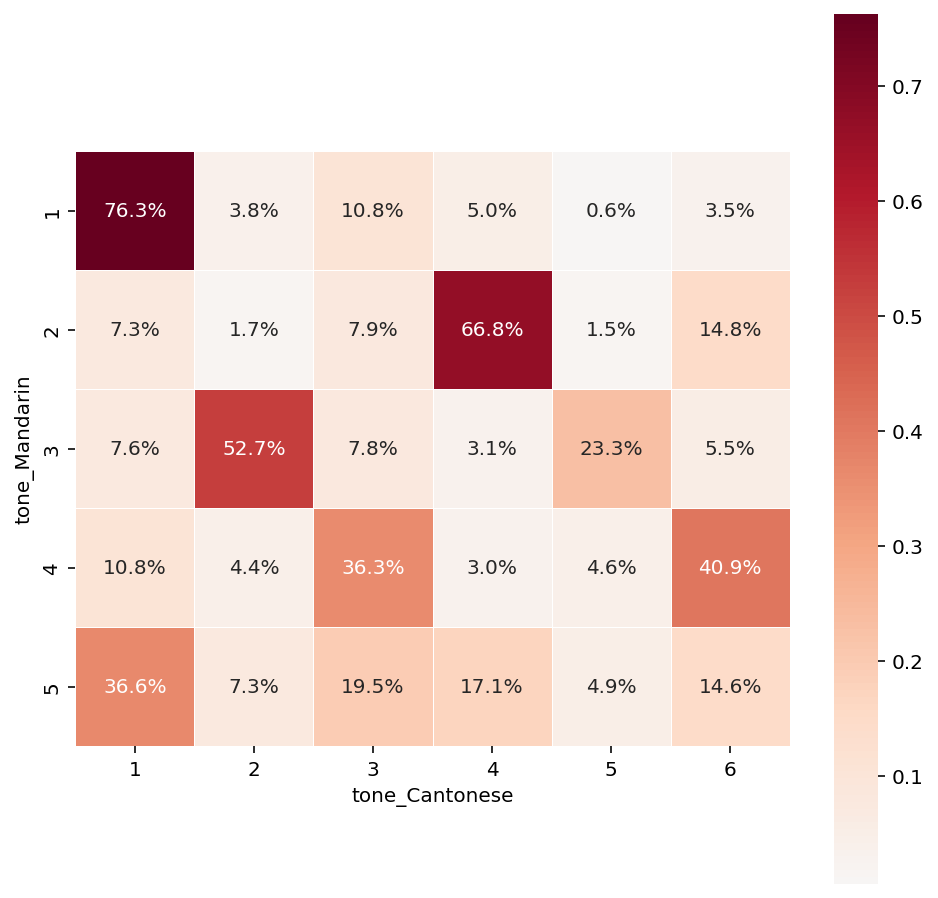

In [92]:
sns.set_context({"figure.figsize":(8,8)})
plot = sns.heatmap(tone_compdf_pct, 
            annot=True, 
            fmt='.1%', 
            center=0,
            linewidths=0.3,square=True, 
            cmap="RdBu_r")
plot

<AxesSubplot:xlabel='initial_Cantonese', ylabel='initial_Mandarin'>

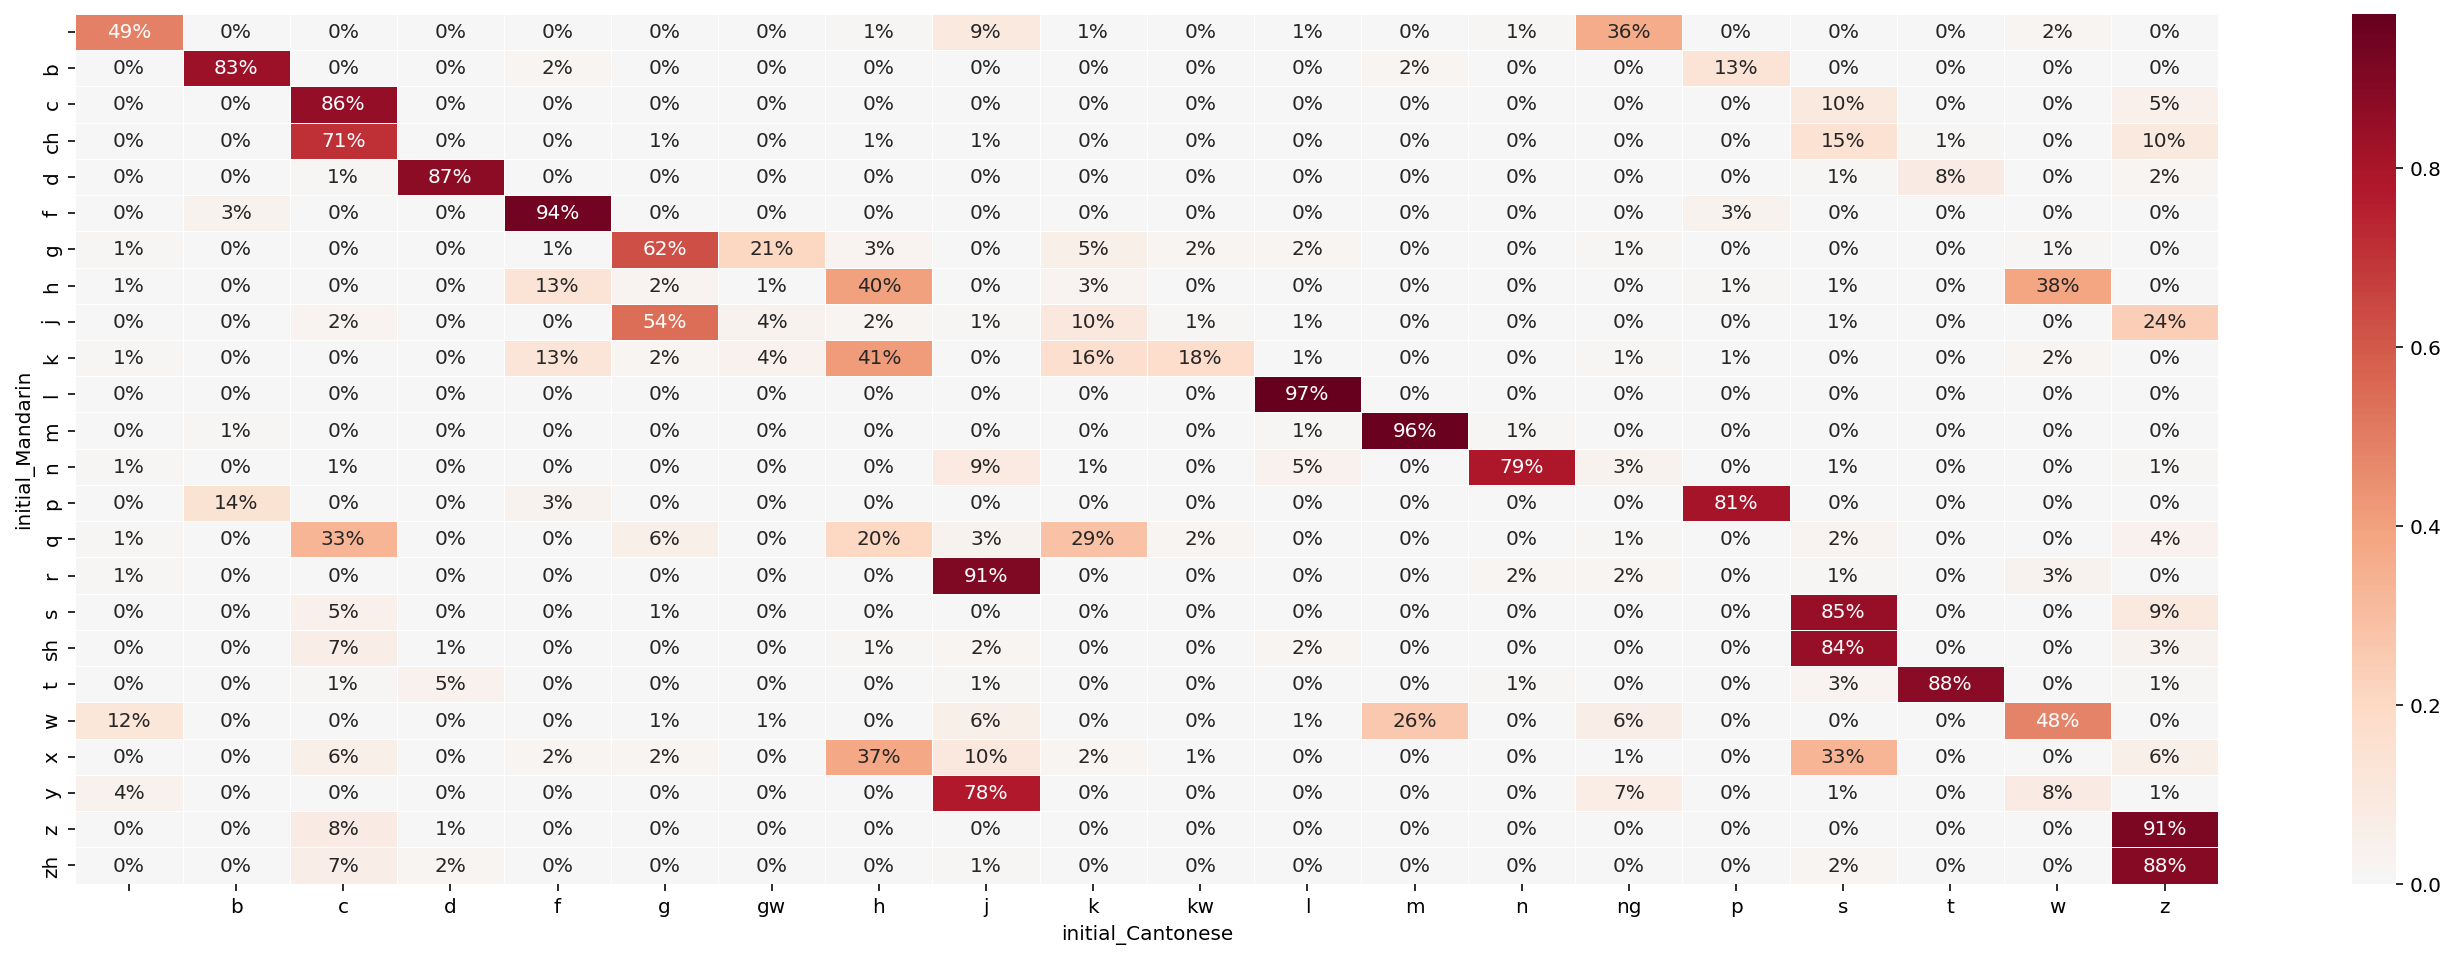

In [93]:
sns.set_context({"figure.figsize":(24,8)})
plot = sns.heatmap(initial_compdf_pct, 
            annot=True, 
            fmt='.0%', 
            center=0,
            linewidths=0.3,
            cmap="RdBu_r")
plot

<AxesSubplot:xlabel='final_Cantonese', ylabel='final_Mandarin'>

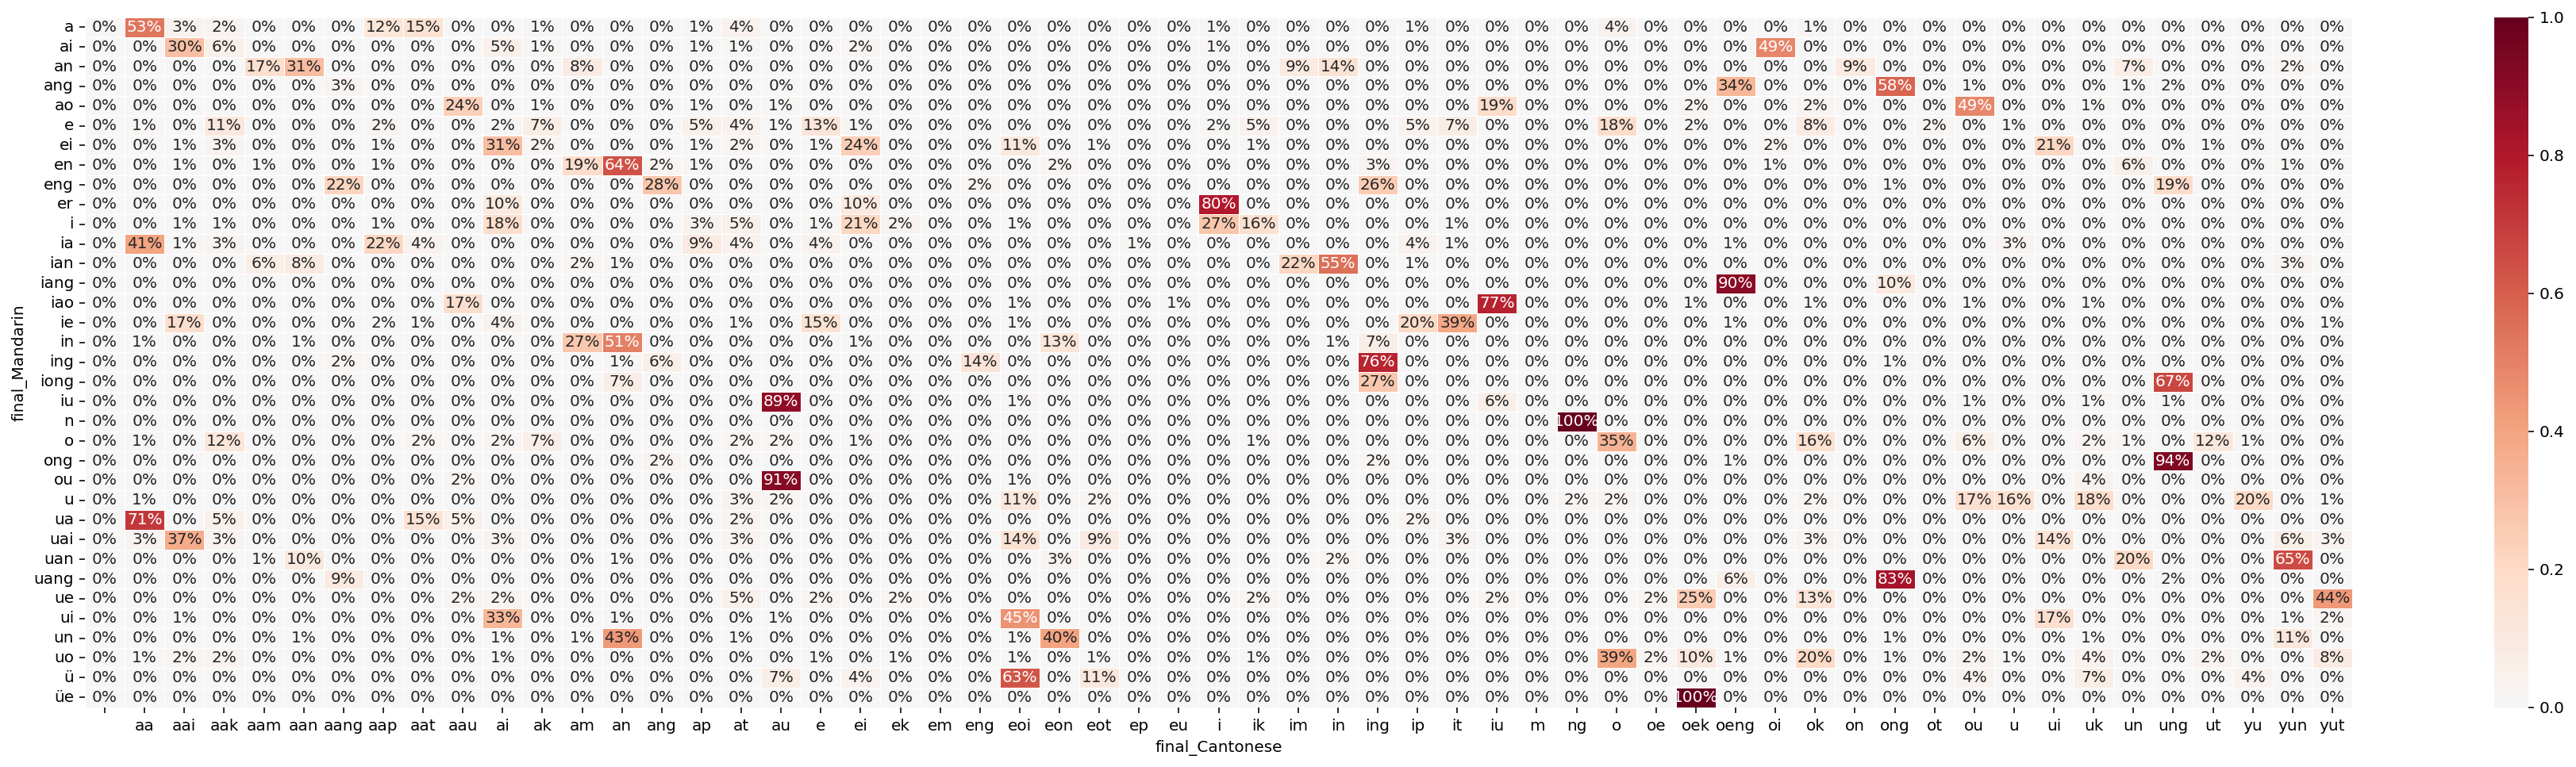

In [94]:
sns.set_context({"figure.figsize":(32,8)})
plot = sns.heatmap(final_compdf_pct, 
            annot=True, 
            fmt='.0%', 
            center=0,
            linewidths=0.3,
            cmap="RdBu_r")
plot